# Notes

We shouldn't use pre-trained model to `sign-language-mnist` because the image size is not sufficient enough to be as input of the selected pre-trained model (MobileNet V2).

## References

Q. Xiang, et.al., (2019) *Fruit Image Classification Based on MobileNetV2 with Transfer Learning Technique*, https://doi.org/10.1145/3331453.3361658

In [13]:
import os
import sys
import random
import shutil
import time
import string


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

from keras_preprocessing import image as keras_prep_image
from tensorflow.keras.utils import to_categorical

In [2]:
tf.__version__

'2.2.0'

In [3]:
# Make numpy values easier to read
np.set_printoptions(precision=3, suppress=True)

# Load data

In [4]:
train_file_path = "dataset/sign-language-mnist/sign_mnist_train.csv"
test_file_path = "dataset/sign-language-mnist/sign_mnist_test.csv"

In [5]:
def read_dataset(filepath):
    with open(filepath, 'r') as f:
        rows = f.readline()
        rows = f.readlines()
        
        label = []
        data = []
        N_rows = len(rows)
        for i, line in enumerate(rows):
            sys.stdout.write('\rProcessing: {:.2f}%'.format((i+1)*100/float(N_rows)))
            sys.stdout.flush()
            line = line.split(',')
            
            #hot_one = np.zeros(26)
            #hot_one[int(line[0])] = 1.
            #label.append(hot_one)
            
            label.append(int(line[0]))
            data.append(np.array([float(pixel.strip('\n')) for pixel in line[1:]]).reshape(28, 28))
            
            #if i == 5:
            #    break
    print("")    
    return np.array(data), np.array(label, dtype=int)

In [11]:
raw_train_images, raw_train_label = read_dataset(train_file_path)
raw_test_images, raw_test_label = read_dataset(test_file_path)

Processing: 100.00%
Processing: 100.00%


In [9]:
print(raw_train_images.shape)
print(train_label.shape)

print(raw_test_images.shape)
print(test_label.shape)

N_train = raw_train_images.shape[0]
N_test = raw_test_images.shape[0]

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [14]:
train_images = raw_train_images.reshape(N_train, 28, 28, 1)
test_images = raw_test_images.reshape(N_test, 28, 28, 1)


num_classes = 26
train_label = to_categorical(raw_train_label, num_classes)
test_label = to_categorical(raw_test_label, num_classes)

Show several images from the training set.

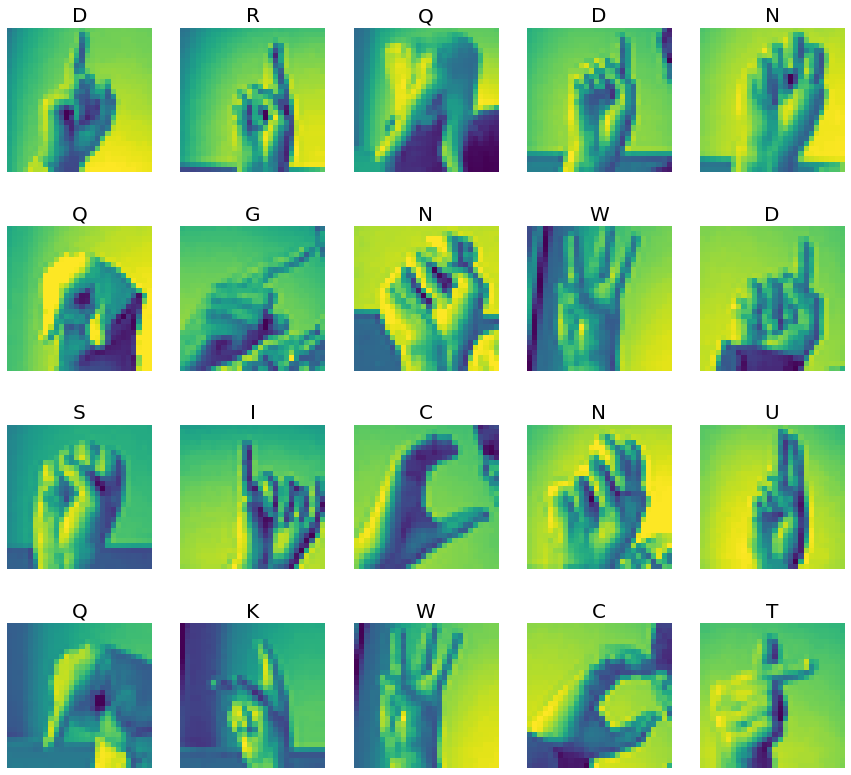

In [15]:
num_images = 20   # Numbers of images plot
num_row = 4       # Axes row setting
letter_map = string.ascii_uppercase[:26]

num_col = int(round(num_images / float(num_row)))

fig, ax = plt.subplots(figsize=(15, 14), 
                       nrows=num_row, 
                       ncols=num_col)

for i, (img_train, img_label) in enumerate(zip(train_images[:num_images], 
                                               train_label[:num_images])):
    img_train = img_train[:, :, 0]
    title = letter_map[img_label.argmax()]
    
    ax[i % num_row, i % num_col].imshow(img_train) 
    ax[i % num_row, i % num_col].set_title(title, fontsize=20)
    ax[i % num_row, i % num_col].axis('off')


In [16]:
# some callbacks for time measurement and early stopping
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.perf_counter()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.perf_counter() - self.epoch_time_start)
        
class LossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get("accuracy") > 0.996:
            print("\nReached 99.6% accuracy so cancelling training!")
            self.model.stop_training = True

time_callback = TimeHistory()
loss_callback = LossCallback()

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = training_datagen.flow(
    train_images, 
    train_label, 
    batch_size=32, 
    shuffle=True
)
validation_generator = validation_datagen.flow(
    test_images, 
    test_label, 
    batch_size=32, 
    shuffle=True
)

Inspect an image

In [17]:
for i, train_batch in enumerate(train_generator):
    image_batch, label_batch = train_batch
    
    image_batch = tf.constant(image_batch)
    label_batch = tf.constant(label_batch)
    
    if i == 0:
        break

image_batch.shape

TensorShape([32, 28, 28, 1])

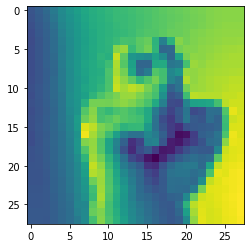

In [19]:
image_batch_ndarray = tf.make_ndarray(tf.make_tensor_proto(image_batch[0]))
plt.imshow(image_batch_ndarray[:, :, 0]);

In [21]:
label_batch[0]

<tf.Tensor: shape=(26,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>

# Layers construction

## Define some layers

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])



## Compile the model

In [23]:
base_learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               2769152   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 26)                6682      
Total params: 2,842,266
Trainable params: 2,842,266
Non-trainable params: 0
______________________________________________

In [25]:
len(model.trainable_variables)

8

## Train the model

In [27]:
initial_epochs = 100
#validation_steps = 20
steps_per_epoch = N_train // 32   # the number of samples in our dataset divided by the batch size
validation_steps = N_test // 32    # Total number of steps (batches of samples) to draw before stopping 
                                    # when performing validation at the end of every epoch

loss0, accuracy0 = model.evaluate(validation_generator, steps=validation_steps)

224/224 [==============================] - 1s 5ms/step - loss: 3.2584 - accuracy: 0.0338


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.26
initial accuracy: 0.03


In [29]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    validation_steps=validation_steps,
                    validation_data=validation_generator,
                    callbacks=[time_callback, loss_callback])

Epoch 1/100
857/857 [==============================] - 15s 18ms/step - loss: 3.0390 - accuracy: 0.2899 - val_loss: 2.9501 - val_accuracy: 0.3849
Epoch 2/100
857/857 [==============================] - 15s 18ms/step - loss: 2.8330 - accuracy: 0.4980 - val_loss: 2.8540 - val_accuracy: 0.4714
Epoch 3/100
857/857 [==============================] - 16s 18ms/step - loss: 2.7505 - accuracy: 0.5789 - val_loss: 2.7639 - val_accuracy: 0.5639
Epoch 4/100
857/857 [==============================] - 17s 19ms/step - loss: 2.6896 - accuracy: 0.6377 - val_loss: 2.7440 - val_accuracy: 0.5773
Epoch 5/100
857/857 [==============================] - 16s 19ms/step - loss: 2.6603 - accuracy: 0.6668 - val_loss: 2.7410 - val_accuracy: 0.5820
Epoch 6/100
857/857 [==============================] - 16s 18ms/step - loss: 2.6343 - accuracy: 0.6914 - val_loss: 2.7123 - val_accuracy: 0.6104
Epoch 7/100
857/857 [==============================] - 16s 19ms/step - loss: 2.6048 - accuracy: 0.7213 - val_loss: 2.6790 - val_ac

857/857 [==============================] - 16s 18ms/step - loss: 2.4051 - accuracy: 0.9170 - val_loss: 2.4995 - val_accuracy: 0.8217
Epoch 58/100
857/857 [==============================] - 16s 18ms/step - loss: 2.4028 - accuracy: 0.9194 - val_loss: 2.5160 - val_accuracy: 0.8054
Epoch 59/100
857/857 [==============================] - 16s 19ms/step - loss: 2.4043 - accuracy: 0.9178 - val_loss: 2.4964 - val_accuracy: 0.8251
Epoch 60/100
857/857 [==============================] - 16s 19ms/step - loss: 2.4068 - accuracy: 0.9154 - val_loss: 2.5317 - val_accuracy: 0.7902
Epoch 61/100
857/857 [==============================] - 16s 19ms/step - loss: 2.4040 - accuracy: 0.9180 - val_loss: 2.5015 - val_accuracy: 0.8202
Epoch 62/100
857/857 [==============================] - 15s 18ms/step - loss: 2.4046 - accuracy: 0.9175 - val_loss: 2.5004 - val_accuracy: 0.8211
Epoch 63/100
857/857 [==============================] - 15s 18ms/step - loss: 2.4034 - accuracy: 0.9186 - val_loss: 2.5070 - val_accuracy

In [30]:
print("total time fitting (approx.): {:.2f} s".format(sum(time_callback.times)))

total time fitting (approx.): 1584.99 s


## Learning curves

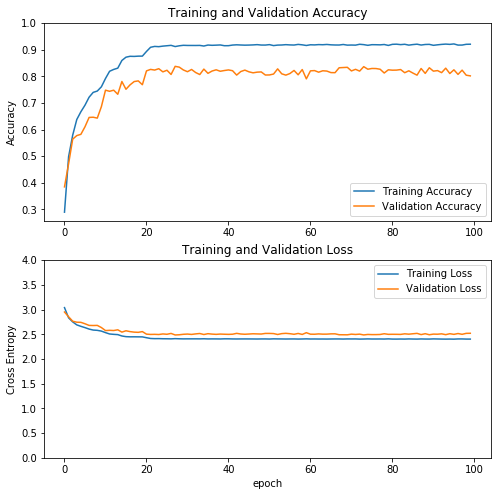

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
num_computed_epochs = len(history.epoch)
print(f"number of computed epochs before the fitting stopped: {num_computed_epochs}")

number of computed epochs before the fitting stopped: 100


In [34]:
alphabet = [letter.upper() for letter in "abcdefghiklmnopqrstuvwxy"]

#fn = "./hand-sign-real-data/D-lugo.jpg"

base_test_dir = "/dataset/DataSet Signos splitted/test"

test_path_all = [os.path.join(base_test_dir, letter_path, image_path) 
                 for letter_path in os.listdir(base_test_dir)
                    for image_path in os.listdir(os.path.join(base_test_dir, letter_path))]
#print(test_path_all)


for fn in test_path_all:
    #break
    img = keras_prep_image.load_img(fn, target_size=input_shape[:2],
                                    color_mode='rgb')
    x = keras_prep_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    classes_name = np.array(alphabet)
    ##print(classes_name[np.array([int(round(p)) for p in classes[0]]) == 1])
    #print(fn, 'is', classes_name[np.array([int(round(p)) for p in classes[0]]) == 1][0])

    #print(classes_name[classes[0].argmin()])
    fn_label = os.path.split(os.path.split(fn)[0])[-1]
    predicted_label = classes_name[classes[0].argmin()]
    print(f"{fn} is {predicted_label} ({fn_label == predicted_label})")

FileNotFoundError: [Errno 2] No such file or directory: '/dataset/DataSet Signos splitted/test'